In [1]:
import os
import copy
import time

import torch
import torch.nn as nn
import torchvision

from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Const variables

# Dataset root
DATASET_DIR_ROOT = "../datasets/eye-dataset"

# Number of epochs
n_epochs = 90

# Input images size
image_size = 256

# Number of batches
batch_size = 32

# Number of workers for dataloaders
num_workers = 4

# **DATA LOADING**

In [3]:
# Define transforms for each dataset separately

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation(45),
    transforms.RandomAdjustSharpness(1.3, 1),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

validation_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

In [4]:
# Load datasets

train_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "train"),
    transform=train_transforms
)

validation_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "validation"),
    transform=validation_transforms
)

test_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "test"),
    transform=test_transforms
)

In [5]:
# Instantiate DataLoaders

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# **DATA VISUALIZATION** 


In [6]:
sns.set_style('darkgrid')

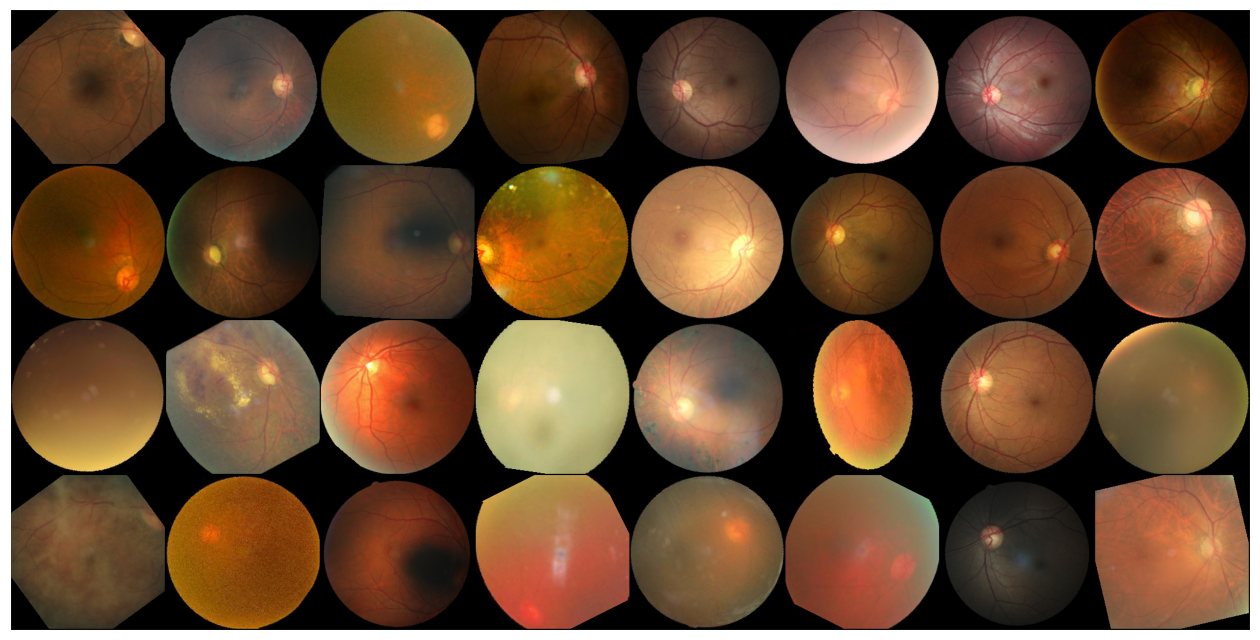

In [7]:
def grid_display(dataloader):
    """Plots a single batch of a dataloader. Denormalizes images for better visualization.

    :param dataloader: a DataLoader object that we want to display its images
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        
grid_display(train_loader)

In [8]:
def label_distribution(dataset):
    """Counts the number of samples per label(class) in the dataset.
    
    :param dataset: the purpose dataset
    :type dataset: ImageFolder
    """
    encoded_labels = {v:k for k, v in dataset.class_to_idx.items()} # {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
    labels_count = {k:0 for k in dataset.class_to_idx} # {'cataract': 0, 'diabetic_retinopathy': 0, 'glaucoma': 0, 'normal': 0}

    for label_code in encoded_labels:
        labels_count[encoded_labels[label_code]] = dataset.targets.count(label_code)
    return labels_count

In [9]:
def plot_from_dict(dict_obj: dict, plot_title: str, **kwargs):
    """Plots a bar chart from a dictionry. keys: x_axis, values: y_axis
    
    :param dict_obj: the dictionary that would be plotted
    :param plot_title: title of the plot
    """
    df = pd.DataFrame.from_dict([dict_obj]).melt()
    df.rename(columns={'variable': 'Dataset Labels', 'value': 'Number of samples'}, inplace=True)
    return sns.barplot(
        data=df,
        x="Dataset Labels",
        y="Number of samples",
        hue="Dataset Labels",
        **kwargs
    ).set_title(label=plot_title)

Text(0.5, 1.0, 'Test Set')

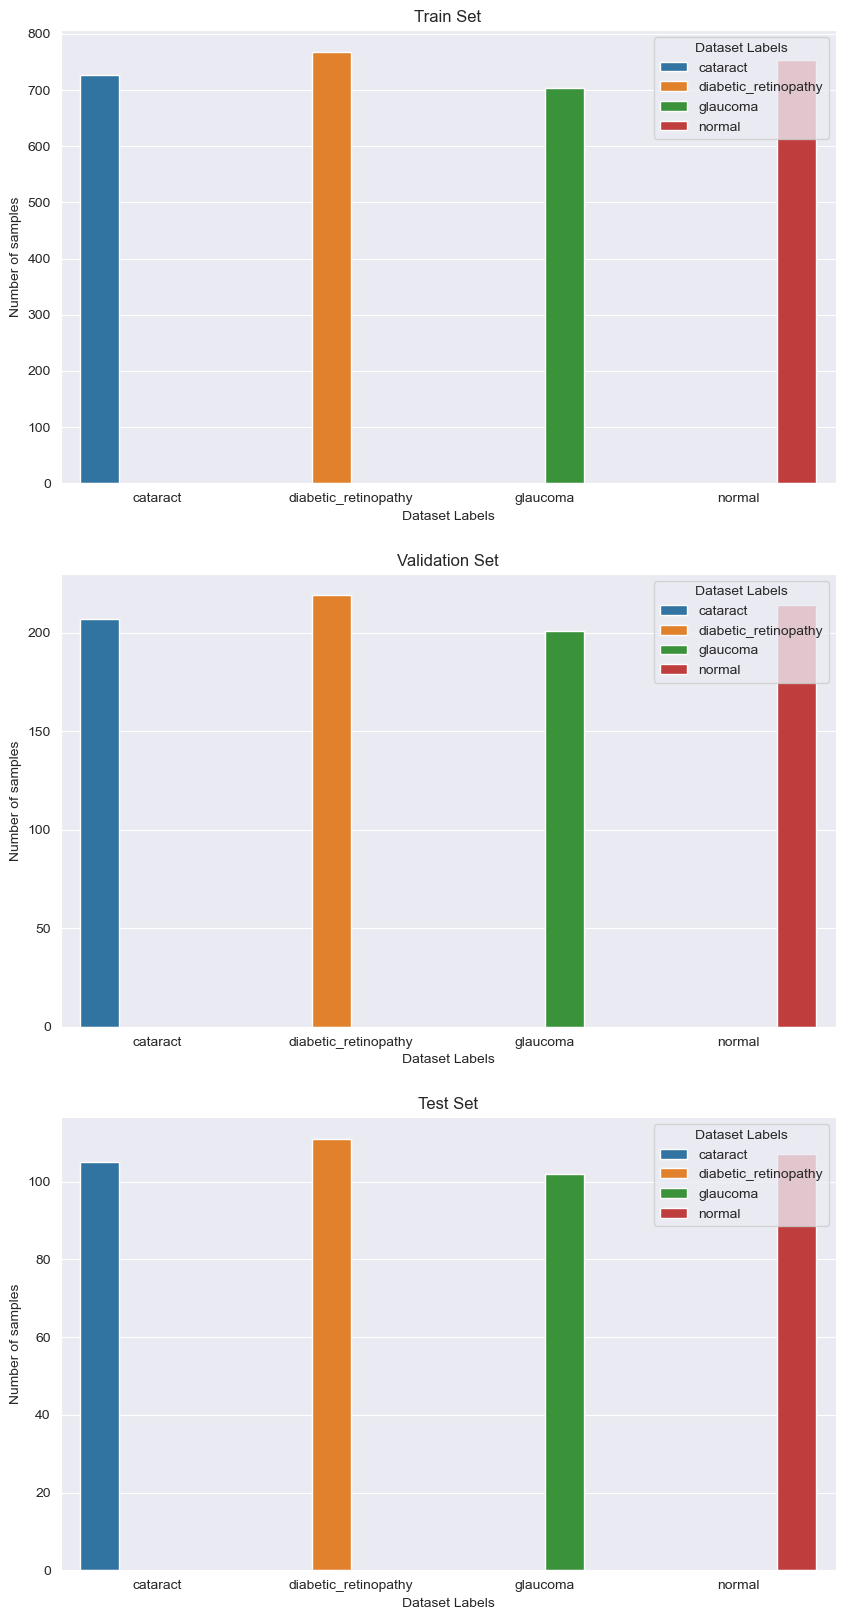

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
plot_from_dict(label_distribution(train_set), plot_title="Train Set", ax=axes[0])
plot_from_dict(label_distribution(validation_set), plot_title="Validation Set", ax=axes[1])
plot_from_dict(label_distribution(test_set), plot_title="Test Set", ax=axes[2])

# **MODEL**

In [11]:
class EyeSeeNet(nn.Module):
    def __init__(self, num_class):
        super(EyeSeeNet, self).__init__()
        self.num_class = num_class
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128*14*14, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_class)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*14*14)
        x = self.fc(x)
        return x

In [12]:
# Summary of the architecture of RetinalEnsemble

summary(EyeSeeNet(4), (3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 16, 254, 254]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 254, 254]        32
|    └─ReLU: 2-3                         [-1, 16, 254, 254]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 127, 127]        --
|    └─Conv2d: 2-5                       [-1, 32, 125, 125]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 125, 125]        64
|    └─ReLU: 2-7                         [-1, 32, 125, 125]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 62, 62]          --
|    └─Conv2d: 2-9                       [-1, 64, 60, 60]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 60, 60]          128
|    └─ReLU: 2-11                        [-1, 64, 60, 60]          --
|    └─MaxPool2d: 2-12                   [-1, 64, 30, 30]          --
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 16, 254, 254]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 254, 254]        32
|    └─ReLU: 2-3                         [-1, 16, 254, 254]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 127, 127]        --
|    └─Conv2d: 2-5                       [-1, 32, 125, 125]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 125, 125]        64
|    └─ReLU: 2-7                         [-1, 32, 125, 125]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 62, 62]          --
|    └─Conv2d: 2-9                       [-1, 64, 60, 60]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 60, 60]          128
|    └─ReLU: 2-11                        [-1, 64, 60, 60]          --
|    └─MaxPool2d: 2-12                   [-1, 64, 30, 30]          --
|    └

In [13]:
# Define device : GPU, MPS, or CPU

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
    
print(device)

mps


In [14]:
# Instanciate and Transfer model on the device

model = EyeSeeNet(4).to(device)

In [15]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# **TRAIN THE MODEL**

In [16]:
# Train model

train_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()

for epoch in range(n_epochs):
    train_corrects = 0
    train_loss = 0.0

    model.train()
    for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{n_epochs}'):

        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == targets.data)
        train_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()
            
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    
    with torch.no_grad():
        val_corrects = 0
        val_loss = 0.0
        model.eval()

        for inputs, targets in tqdm(validation_loader, desc=f'Validating... Epoch: {epoch + 1}/{n_epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects / len(validation_loader.dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # save epoch losses
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print('-'*30)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
model.load_state_dict(best_model_wts)

Validating... Epoch: 1/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 1/90:
Train Loss: 1.1175, Train Accuracy: 0.5134
Validation Loss: 0.9369, Validation Accuracy: 0.6314
------------------------------


Validating... Epoch: 2/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 2/90:
Train Loss: 0.8295, Train Accuracy: 0.6513
Validation Loss: 0.7619, Validation Accuracy: 0.7027
------------------------------


Validating... Epoch: 3/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 3/90:
Train Loss: 0.7043, Train Accuracy: 0.7018
Validation Loss: 0.7065, Validation Accuracy: 0.7087
------------------------------


Validating... Epoch: 4/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 4/90:
Train Loss: 0.6381, Train Accuracy: 0.7330
Validation Loss: 0.6231, Validation Accuracy: 0.7337
------------------------------


Validating... Epoch: 5/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 5/90:
Train Loss: 0.5746, Train Accuracy: 0.7614
Validation Loss: 0.5780, Validation Accuracy: 0.7681
------------------------------


Validating... Epoch: 6/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 6/90:
Train Loss: 0.5398, Train Accuracy: 0.7757
Validation Loss: 0.5502, Validation Accuracy: 0.7776
------------------------------


Validating... Epoch: 7/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 7/90:
Train Loss: 0.4943, Train Accuracy: 0.7970
Validation Loss: 0.5191, Validation Accuracy: 0.8002
------------------------------


Validating... Epoch: 8/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 8/90:
Train Loss: 0.4991, Train Accuracy: 0.7923
Validation Loss: 0.5537, Validation Accuracy: 0.7681
------------------------------


Validating... Epoch: 9/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 9/90:
Train Loss: 0.4625, Train Accuracy: 0.8065
Validation Loss: 0.4896, Validation Accuracy: 0.8002
------------------------------


Validating... Epoch: 10/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 10/90:
Train Loss: 0.4564, Train Accuracy: 0.8190
Validation Loss: 0.4467, Validation Accuracy: 0.8264
------------------------------


Validating... Epoch: 11/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 11/90:
Train Loss: 0.4293, Train Accuracy: 0.8251
Validation Loss: 0.4457, Validation Accuracy: 0.8205
------------------------------


Validating... Epoch: 12/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 12/90:
Train Loss: 0.4135, Train Accuracy: 0.8279
Validation Loss: 0.4393, Validation Accuracy: 0.8252
------------------------------


Validating... Epoch: 13/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 13/90:
Train Loss: 0.3862, Train Accuracy: 0.8455
Validation Loss: 0.4985, Validation Accuracy: 0.8086
------------------------------


Validating... Epoch: 14/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.14it/s]


Epoch 14/90:
Train Loss: 0.3669, Train Accuracy: 0.8512
Validation Loss: 0.4231, Validation Accuracy: 0.8419
------------------------------


Validating... Epoch: 15/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 15/90:
Train Loss: 0.4181, Train Accuracy: 0.8282
Validation Loss: 0.4035, Validation Accuracy: 0.8395
------------------------------


Validating... Epoch: 16/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 16/90:
Train Loss: 0.3552, Train Accuracy: 0.8553
Validation Loss: 0.4413, Validation Accuracy: 0.8240
------------------------------


Validating... Epoch: 17/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 17/90:
Train Loss: 0.3704, Train Accuracy: 0.8577
Validation Loss: 0.4077, Validation Accuracy: 0.8549
------------------------------


Validating... Epoch: 18/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 18/90:
Train Loss: 0.3109, Train Accuracy: 0.8739
Validation Loss: 0.3756, Validation Accuracy: 0.8490
------------------------------


Validating... Epoch: 19/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 19/90:
Train Loss: 0.3235, Train Accuracy: 0.8699
Validation Loss: 0.3953, Validation Accuracy: 0.8490
------------------------------


Validating... Epoch: 20/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.14it/s]


Epoch 20/90:
Train Loss: 0.2962, Train Accuracy: 0.8780
Validation Loss: 0.4032, Validation Accuracy: 0.8395
------------------------------


Validating... Epoch: 21/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 21/90:
Train Loss: 0.3123, Train Accuracy: 0.8692
Validation Loss: 0.3973, Validation Accuracy: 0.8454
------------------------------


Validating... Epoch: 22/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 22/90:
Train Loss: 0.2629, Train Accuracy: 0.8973
Validation Loss: 0.3240, Validation Accuracy: 0.8775
------------------------------


Validating... Epoch: 23/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 23/90:
Train Loss: 0.2755, Train Accuracy: 0.8929
Validation Loss: 0.3009, Validation Accuracy: 0.8870
------------------------------


Validating... Epoch: 24/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 24/90:
Train Loss: 0.2389, Train Accuracy: 0.9085
Validation Loss: 0.3695, Validation Accuracy: 0.8728
------------------------------


Validating... Epoch: 25/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 25/90:
Train Loss: 0.2298, Train Accuracy: 0.9143
Validation Loss: 0.2956, Validation Accuracy: 0.8930
------------------------------


Validating... Epoch: 26/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 26/90:
Train Loss: 0.2358, Train Accuracy: 0.8980
Validation Loss: 0.3471, Validation Accuracy: 0.8751
------------------------------


Validating... Epoch: 27/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 27/90:
Train Loss: 0.2485, Train Accuracy: 0.8987
Validation Loss: 0.3497, Validation Accuracy: 0.8633
------------------------------


Validating... Epoch: 28/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 28/90:
Train Loss: 0.2101, Train Accuracy: 0.9160
Validation Loss: 0.2497, Validation Accuracy: 0.9132
------------------------------


Validating... Epoch: 29/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 29/90:
Train Loss: 0.2015, Train Accuracy: 0.9183
Validation Loss: 0.3265, Validation Accuracy: 0.8894
------------------------------


Validating... Epoch: 30/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.14it/s]


Epoch 30/90:
Train Loss: 0.1709, Train Accuracy: 0.9329
Validation Loss: 0.3078, Validation Accuracy: 0.9049
------------------------------


Validating... Epoch: 31/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 31/90:
Train Loss: 0.2192, Train Accuracy: 0.9132
Validation Loss: 0.2709, Validation Accuracy: 0.9073
------------------------------


Validating... Epoch: 32/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 32/90:
Train Loss: 0.1879, Train Accuracy: 0.9268
Validation Loss: 0.2520, Validation Accuracy: 0.9108
------------------------------


Validating... Epoch: 33/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 33/90:
Train Loss: 0.1646, Train Accuracy: 0.9315
Validation Loss: 0.2525, Validation Accuracy: 0.9156
------------------------------


Validating... Epoch: 34/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 34/90:
Train Loss: 0.1661, Train Accuracy: 0.9360
Validation Loss: 0.2231, Validation Accuracy: 0.9203
------------------------------


Validating... Epoch: 35/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 35/90:
Train Loss: 0.1685, Train Accuracy: 0.9319
Validation Loss: 0.2379, Validation Accuracy: 0.9191
------------------------------


Validating... Epoch: 36/90: 100%|█████████████████████████████████████████████| 27/27 [12:03<00:00, 26.78s/it]


Epoch 36/90:
Train Loss: 0.1712, Train Accuracy: 0.9309
Validation Loss: 0.2314, Validation Accuracy: 0.9156
------------------------------


Validating... Epoch: 37/90: 100%|█████████████████████████████████████████████| 27/27 [06:11<00:00, 13.77s/it]


Epoch 37/90:
Train Loss: 0.1528, Train Accuracy: 0.9437
Validation Loss: 0.2190, Validation Accuracy: 0.9251
------------------------------


Validating... Epoch: 38/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 38/90:
Train Loss: 0.1455, Train Accuracy: 0.9407
Validation Loss: 0.2583, Validation Accuracy: 0.9096
------------------------------


Validating... Epoch: 39/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 39/90:
Train Loss: 0.1519, Train Accuracy: 0.9434
Validation Loss: 0.2222, Validation Accuracy: 0.9168
------------------------------


Validating... Epoch: 40/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 40/90:
Train Loss: 0.1210, Train Accuracy: 0.9536
Validation Loss: 0.2458, Validation Accuracy: 0.9144
------------------------------


Validating... Epoch: 41/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 41/90:
Train Loss: 0.1526, Train Accuracy: 0.9427
Validation Loss: 0.2280, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 42/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 42/90:
Train Loss: 0.1156, Train Accuracy: 0.9559
Validation Loss: 0.5429, Validation Accuracy: 0.8383
------------------------------


Validating... Epoch: 43/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 43/90:
Train Loss: 0.1448, Train Accuracy: 0.9444
Validation Loss: 0.2800, Validation Accuracy: 0.9037
------------------------------


Validating... Epoch: 44/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 44/90:
Train Loss: 0.1346, Train Accuracy: 0.9444
Validation Loss: 0.4404, Validation Accuracy: 0.8728
------------------------------


Validating... Epoch: 45/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 45/90:
Train Loss: 0.1351, Train Accuracy: 0.9461
Validation Loss: 0.3265, Validation Accuracy: 0.8894
------------------------------


Validating... Epoch: 46/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 46/90:
Train Loss: 0.1039, Train Accuracy: 0.9590
Validation Loss: 0.2065, Validation Accuracy: 0.9275
------------------------------


Validating... Epoch: 47/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 47/90:
Train Loss: 0.1168, Train Accuracy: 0.9526
Validation Loss: 0.2460, Validation Accuracy: 0.9191
------------------------------


Validating... Epoch: 48/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 48/90:
Train Loss: 0.1264, Train Accuracy: 0.9519
Validation Loss: 0.2706, Validation Accuracy: 0.9132
------------------------------


Validating... Epoch: 49/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 49/90:
Train Loss: 0.1178, Train Accuracy: 0.9532
Validation Loss: 0.2425, Validation Accuracy: 0.9108
------------------------------


Validating... Epoch: 50/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 50/90:
Train Loss: 0.1042, Train Accuracy: 0.9593
Validation Loss: 0.2046, Validation Accuracy: 0.9382
------------------------------


Validating... Epoch: 51/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 51/90:
Train Loss: 0.0965, Train Accuracy: 0.9648
Validation Loss: 0.2579, Validation Accuracy: 0.9144
------------------------------


Validating... Epoch: 52/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 52/90:
Train Loss: 0.0916, Train Accuracy: 0.9665
Validation Loss: 0.1948, Validation Accuracy: 0.9417
------------------------------


Validating... Epoch: 53/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 53/90:
Train Loss: 0.1151, Train Accuracy: 0.9566
Validation Loss: 0.2582, Validation Accuracy: 0.9037
------------------------------


Validating... Epoch: 54/90: 100%|█████████████████████████████████████████████| 27/27 [00:24<00:00,  1.12it/s]


Epoch 54/90:
Train Loss: 0.0830, Train Accuracy: 0.9695
Validation Loss: 0.2315, Validation Accuracy: 0.9239
------------------------------


Validating... Epoch: 55/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 55/90:
Train Loss: 0.1002, Train Accuracy: 0.9614
Validation Loss: 0.2218, Validation Accuracy: 0.9239
------------------------------


Validating... Epoch: 56/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 56/90:
Train Loss: 0.1010, Train Accuracy: 0.9620
Validation Loss: 0.1939, Validation Accuracy: 0.9465
------------------------------


Validating... Epoch: 57/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 57/90:
Train Loss: 0.1334, Train Accuracy: 0.9495
Validation Loss: 0.2307, Validation Accuracy: 0.9180
------------------------------


Validating... Epoch: 58/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 58/90:
Train Loss: 0.0895, Train Accuracy: 0.9661
Validation Loss: 0.3587, Validation Accuracy: 0.9073
------------------------------


Validating... Epoch: 59/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 59/90:
Train Loss: 0.0935, Train Accuracy: 0.9620
Validation Loss: 0.2565, Validation Accuracy: 0.9191
------------------------------


Validating... Epoch: 60/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 60/90:
Train Loss: 0.0864, Train Accuracy: 0.9709
Validation Loss: 0.2132, Validation Accuracy: 0.9370
------------------------------


Validating... Epoch: 61/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 61/90:
Train Loss: 0.0946, Train Accuracy: 0.9624
Validation Loss: 0.2122, Validation Accuracy: 0.9394
------------------------------


Validating... Epoch: 62/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 62/90:
Train Loss: 0.0698, Train Accuracy: 0.9722
Validation Loss: 0.2263, Validation Accuracy: 0.9382
------------------------------


Validating... Epoch: 63/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 63/90:
Train Loss: 0.0857, Train Accuracy: 0.9648
Validation Loss: 0.2533, Validation Accuracy: 0.9322
------------------------------


Validating... Epoch: 64/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 64/90:
Train Loss: 0.0791, Train Accuracy: 0.9732
Validation Loss: 0.2473, Validation Accuracy: 0.9346
------------------------------


Validating... Epoch: 65/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 65/90:
Train Loss: 0.0836, Train Accuracy: 0.9671
Validation Loss: 0.1987, Validation Accuracy: 0.9298
------------------------------


Validating... Epoch: 66/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 66/90:
Train Loss: 0.0720, Train Accuracy: 0.9715
Validation Loss: 0.1731, Validation Accuracy: 0.9453
------------------------------


Validating... Epoch: 67/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 67/90:
Train Loss: 0.0810, Train Accuracy: 0.9681
Validation Loss: 0.2364, Validation Accuracy: 0.9251
------------------------------


Validating... Epoch: 68/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 68/90:
Train Loss: 0.0827, Train Accuracy: 0.9658
Validation Loss: 0.1936, Validation Accuracy: 0.9382
------------------------------


Validating... Epoch: 69/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 69/90:
Train Loss: 0.0723, Train Accuracy: 0.9726
Validation Loss: 0.1951, Validation Accuracy: 0.9489
------------------------------


Validating... Epoch: 70/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 70/90:
Train Loss: 0.0544, Train Accuracy: 0.9790
Validation Loss: 0.2646, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 71/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 71/90:
Train Loss: 0.0635, Train Accuracy: 0.9742
Validation Loss: 0.2045, Validation Accuracy: 0.9429
------------------------------


Validating... Epoch: 72/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 72/90:
Train Loss: 0.1014, Train Accuracy: 0.9654
Validation Loss: 0.2281, Validation Accuracy: 0.9275
------------------------------


Validating... Epoch: 73/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 73/90:
Train Loss: 0.0699, Train Accuracy: 0.9705
Validation Loss: 0.1815, Validation Accuracy: 0.9394
------------------------------


Validating... Epoch: 74/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 74/90:
Train Loss: 0.0616, Train Accuracy: 0.9729
Validation Loss: 0.2282, Validation Accuracy: 0.9346
------------------------------


Validating... Epoch: 75/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 75/90:
Train Loss: 0.0704, Train Accuracy: 0.9726
Validation Loss: 0.1968, Validation Accuracy: 0.9370
------------------------------


Validating... Epoch: 76/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 76/90:
Train Loss: 0.0516, Train Accuracy: 0.9814
Validation Loss: 0.2046, Validation Accuracy: 0.9405
------------------------------


Validating... Epoch: 77/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 77/90:
Train Loss: 0.0710, Train Accuracy: 0.9705
Validation Loss: 0.2048, Validation Accuracy: 0.9394
------------------------------


Validating... Epoch: 78/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 78/90:
Train Loss: 0.0621, Train Accuracy: 0.9776
Validation Loss: 0.2835, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 79/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 79/90:
Train Loss: 0.0502, Train Accuracy: 0.9817
Validation Loss: 0.2430, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 80/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 80/90:
Train Loss: 0.0476, Train Accuracy: 0.9824
Validation Loss: 0.2544, Validation Accuracy: 0.9334
------------------------------


Validating... Epoch: 81/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 81/90:
Train Loss: 0.0490, Train Accuracy: 0.9797
Validation Loss: 0.1986, Validation Accuracy: 0.9524
------------------------------


Validating... Epoch: 82/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 82/90:
Train Loss: 0.0563, Train Accuracy: 0.9817
Validation Loss: 0.1752, Validation Accuracy: 0.9489
------------------------------


Validating... Epoch: 83/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 83/90:
Train Loss: 0.0443, Train Accuracy: 0.9848
Validation Loss: 0.2518, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 84/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 84/90:
Train Loss: 0.0424, Train Accuracy: 0.9820
Validation Loss: 0.2469, Validation Accuracy: 0.9370
------------------------------


Validating... Epoch: 85/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 85/90:
Train Loss: 0.0548, Train Accuracy: 0.9787
Validation Loss: 0.2050, Validation Accuracy: 0.9417
------------------------------


Validating... Epoch: 86/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 86/90:
Train Loss: 0.0517, Train Accuracy: 0.9814
Validation Loss: 0.1812, Validation Accuracy: 0.9453
------------------------------


Validating... Epoch: 87/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 87/90:
Train Loss: 0.0370, Train Accuracy: 0.9844
Validation Loss: 0.2327, Validation Accuracy: 0.9394
------------------------------


Validating... Epoch: 88/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 88/90:
Train Loss: 0.0395, Train Accuracy: 0.9848
Validation Loss: 0.2425, Validation Accuracy: 0.9358
------------------------------


Validating... Epoch: 89/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 89/90:
Train Loss: 0.0573, Train Accuracy: 0.9759
Validation Loss: 0.3082, Validation Accuracy: 0.9144
------------------------------


Validating... Epoch: 90/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]

Epoch 90/90:
Train Loss: 0.0536, Train Accuracy: 0.9807
Validation Loss: 0.2049, Validation Accuracy: 0.9382
------------------------------
Training complete in 111m 8s


<All keys matched successfully>

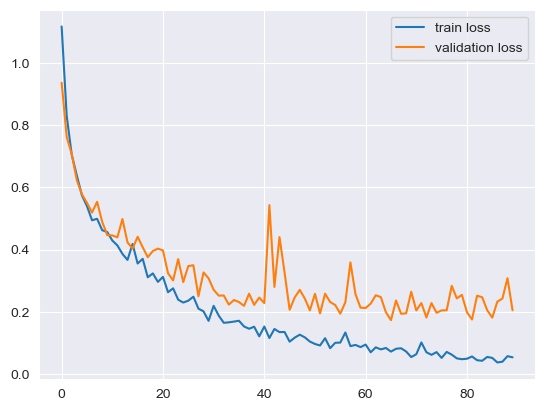

In [24]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()

# **TEST & EVALUATION**



In [25]:
# Calculate Train and Validation Accuracy

def cal_accuracy(data_loader):
    n_correct = 0
    n_total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    accuracy = n_correct / n_total

    return accuracy


print(f"Train Accuracy: {cal_accuracy(train_loader):.4f}, Validation Accuracy: {cal_accuracy(validation_loader):.4f}, Test Accuracy: {cal_accuracy(test_loader):.4f}")

Train Accuracy: 0.9861, Validation Accuracy: 0.9524, Test Accuracy: 0.9412


In [26]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        y_true_list.append(targets.cpu().numpy())
        y_pred_list.append(predictions.cpu().numpy())

# flatten data of batches into a 1-d list
y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

In [27]:
# Classification Report

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       105
           1       1.00      0.94      0.97       111
           2       0.91      0.90      0.91       102
           3       0.93      0.97      0.95       107

    accuracy                           0.94       425
   macro avg       0.94      0.94      0.94       425
weighted avg       0.94      0.94      0.94       425



In [28]:
# Confusion Matrix

print(confusion_matrix(y_true_list, y_pred_list))

[[100   0   5   0]
 [  0 104   2   5]
 [  7   0  92   3]
 [  1   0   2 104]]


<AxesSubplot: >

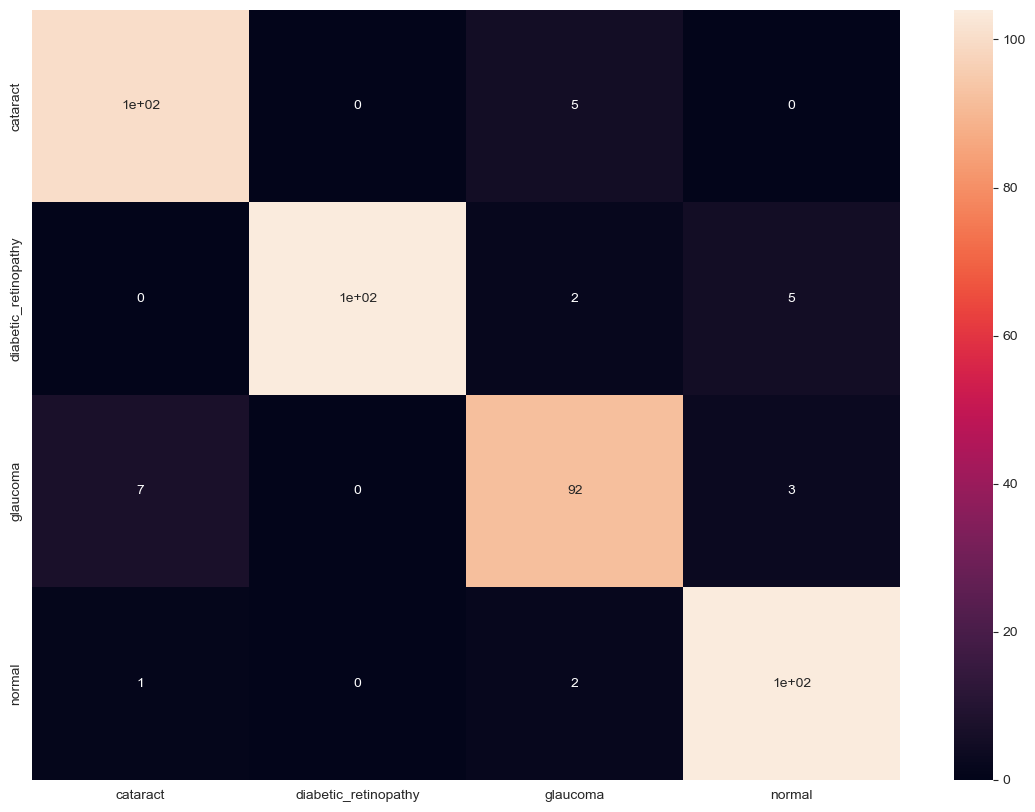

In [29]:
# Plot the Confusion Matrix

def plot_confusion_matrix(dataset, y_true_list, y_pred_list):
    index_to_label = {v:k for k, v in dataset.class_to_idx.items()}
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=index_to_label, index=index_to_label)
    fig, ax = plt.subplots(figsize=(14,10))         
    return sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


plot_confusion_matrix(test_set, y_true_list, y_pred_list)

# **MISCLASSIFIED SAMPLES**

25 of Misclassified Images:


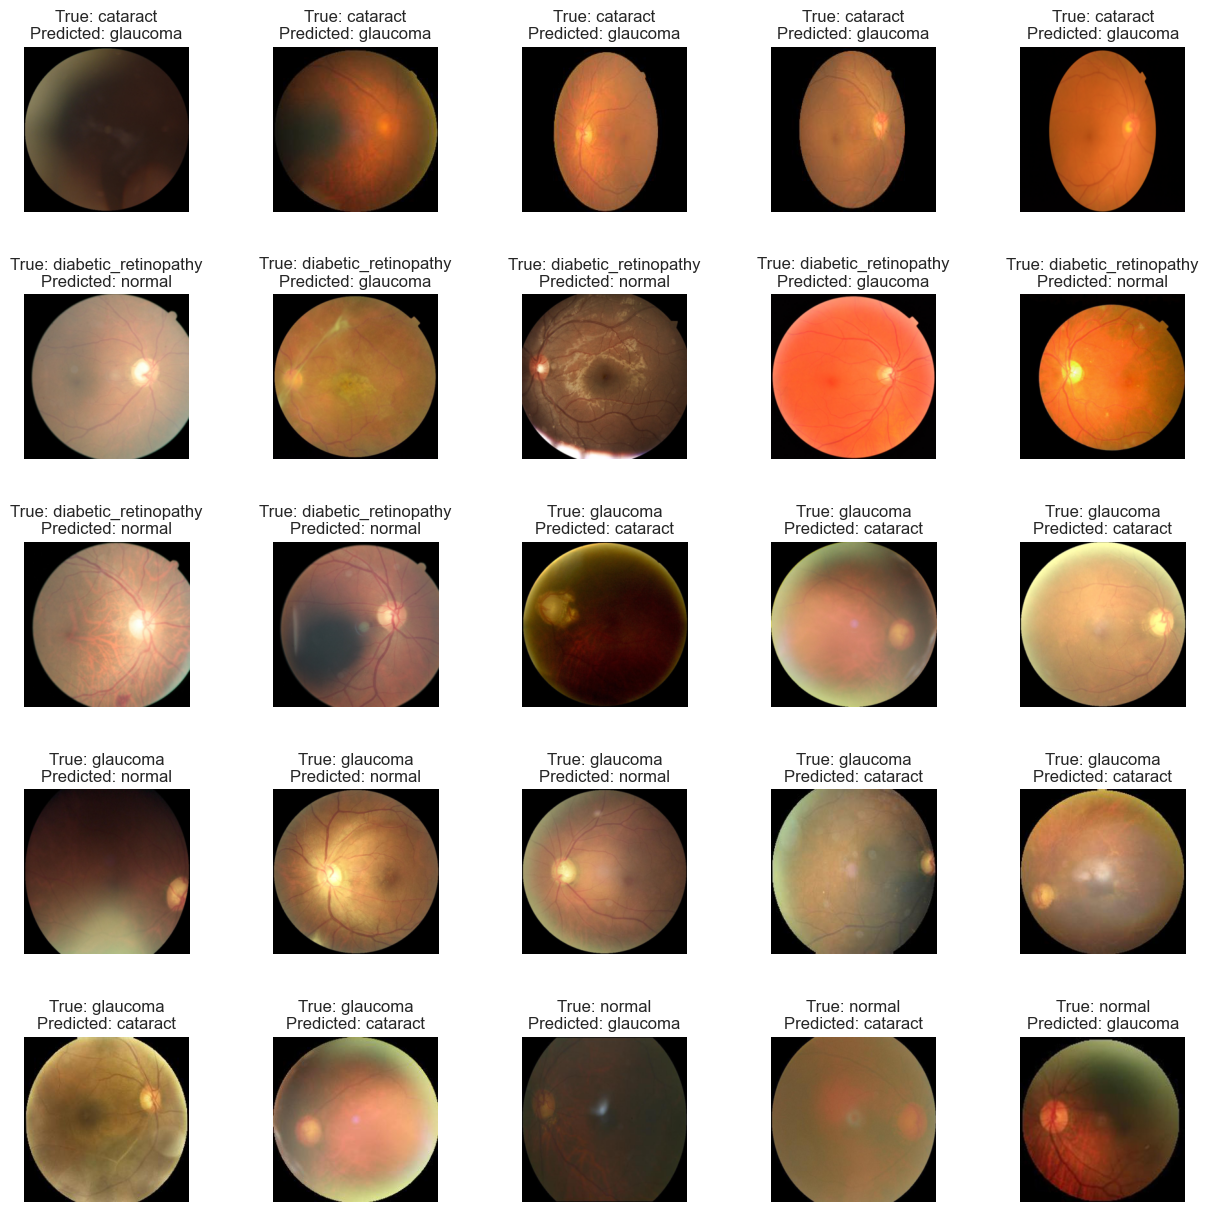

In [23]:
# Plot some of misclassified instances

n_missclassified = 25

encoded_labels = {v:k for k, v in train_set.class_to_idx.items()}
misclassified_idx = np.where(np.array(y_true_list) != np.array(y_pred_list))[0]

print(f"{n_missclassified} of Misclassified Images:")
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, mis_index in enumerate(misclassified_idx[:n_missclassified]):
    ax = axes.ravel()[i]
    ax.imshow(test_set[mis_index][0].permute(1, 2, 0))
    ax.set_title(f"True: {encoded_labels[y_true_list[mis_index]]}\nPredicted: {encoded_labels[y_pred_list[mis_index]]}")
    ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()